In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

# Approximate Bayesian Computation
**Sarah Filippi**

## Introduction

For likelihood-free models we typically need to define 
* an observation,
* a simulator to generate simulated data,
* a prior distribution on the parameter of interest,
* and a distance to compare simulated data and observed data (potentially via summary statistics).

## A simple example with a conjugate prior

We start with a very simple example for which the posterior distribution can be obtained analytically. For such example there is obviously no need to use an Approximate Bayesian Computation (ABC) approach but this is a good way to illustrate and evaluate how the ABC method works. 

We assume that the data, $x_0$, is a sample of size $n$ from a Gaussian distribution with mean $\mu$ and variance $\sigma^2$. The aim of the procedure is to infer the posterior distribution over $(\mu,\sigma^2)$.

We assume a Normal-inverse Gamma prior which is a conjugate prior for inferring $(\mu,\sigma^2)$. More precisely, assuming $(\mu,sigma^2)\sim N\Gamma(\mu_0,\nu,\alpha,\beta)$, the posterior distribution of $(\mu,\sigma^2)|x_0$ also follows a Normal-inverse Gamma
$$(\mu,sigma^2)|x_0\sim N\Gamma(\tilde\mu_0,\tilde\nu,\tilde\alpha,\tilde\beta)$$
where
$\tilde\mu_0 = (\nu\mu0 + n\bar{x})/(\nu+n)$, $\tilde\nu = \nu + n$, $\tilde\alpha = \alpha + n/2$ and $\tilde\beta = \beta + \frac{1}{2}\sum_{i=1}^n(x_i-\bar{x})^2 + \frac{n\nu}{n+\nu} \frac{(\bar{x}-\mu0)^2}{2}$.

Let's first define the simulator which takes as input the batch_size, $n$, and a parameter vector $(\mu,\sigma^2)$ and returns the sample mean and the sample variance. 

In [2]:
def simulator_normal(param, batch_size):
    mu, sigma2 = param[:]
    s = ss.norm.rvs(loc=mu, scale=np.sqrt(sigma2), size=batch_size)
    return s

In this example, we assume that the observed data, $x_0$, are exactly generated from the simulator. In particular we will that is a sample of size 30 from a Gaussian distribution with mean 0 and variance 0.1. To generate the observed data we therefore call the simulator with batch_size=30 and $(\mu,\sigma^2)=(0,0.1)$

In [3]:
mu, sigma2 = 0, 0.1
param=(mu, sigma2)
batch_size = 30
x0 = simulator_normal(param,batch_size)

As described above, we consider a Normal-inverse Gamma prior. We define a function that samples from such a distribution with hyper parameters $(\mu0, \nu, \alpha, \beta)$. The function below returns only one sample from this distribution. We could of course modify it to return more samples.

In [4]:
def prior_sample_ig(hyper_param):
    mu0, nu, alpha, beta = hyper_param[:]
    ps = np.zeros(2)
    ps[1] = ss.invgamma.rvs(alpha, scale=beta, size=1)
    ps[0] = ss.norm.rvs(loc=mu0, scale=np.sqrt(ps[1]/nu), size=1)
    return ps


To finish we need to define a distance measure to compare the simulated data to the observed ones. Here we consider the euclidian distance between the sample mean and the sample variance.

In [5]:
def distance_euclidian_sample_mean_var(s,x_0):
    d2 = (np.mean(s)-np.mean(x_0))**2 + (np.var(s)-np.var(x_0))**2
    return np.sqrt(d2)

We can now implement the ABC algorithm itself. The function takes as input:
* the simulator (simulator) and its arguments (simulator_args)
* the function to sample from the prior (prior_sample), and its arguments (prior_args)
* the number of samples (niter) we want to draw from the the approximate posterior
* the data (x0)
* the threshold (epsilon)
* and the distance function.

The algorithm consists in generating parameters from the prior and simulating data from the model with these parameters until the  distance between the simulated and the observed data is smaller than the threshold epsilon. This procedure is repeated for niter times.

This way, the algorith returns a sample of size niter from the approximate posterior with threshold epsilon.

In [6]:
def rejectionABC(simulator, simulator_args, prior_sample, prior_args, niter, x0, epsilon, distance):
    
    npar = len(prior_sample(prior_args))
    sample = np.zeros((niter,npar))
    totit = 0
    for i in tqdm_notebook(range(0,niter),desc='Samples'):
        totit = totit+1
        param = prior_sample(prior_args)
        s = simulator(param, simulator_args)
        while (distance(s,x0)>epsilon):
            totit = totit+1
            param = prior_sample(prior_args)
            s = simulator(param, simulator_args)
        sample[i,:]=param
    print('To obtain a sample of size %d, the algorithm had to simulate the model %d times. The average acceptance rate is therefore %f.' %(niter,totit, 1.0*niter/totit))
    return sample

Let's try the algorithm on the example we just introduced to produce a sample of size niter=100 from the approximate posterior distribution with a threshold epsilon=0.01. 
* The simulator is the simulator_normal function with argument the batch size equal to $30$. 
* The prior_sample function is then the prior_sample_ig function with argument $(\mu_0,\nu,\alpha,\beta)= (0,1,5,1)$. 
* The distance function is the distance_euclidian_sample_mean_var.

In order to sample a sample of size niter=100 from the approximate posterior with a threshold $\epsilon=0.01$, we will keep generating parameters from the prior and simulate data from the model with these parameters until the euclidian distance between the simulated and the observed data is smaller than $\epsilon=0.01$. This will be repeated niter=100 times.

In [7]:
prior_args = (0,1,5,1)
n = 30
simulator_args = n
niter=100
epsilon=0.1
sample = rejectionABC(simulator_normal, simulator_args, 
                      prior_sample_ig, prior_args, 
                      niter, 
                      x0, 
                      epsilon,
                      distance_euclidian_sample_mean_var)



To obtain a sample of size 100, the algorithm had to simulate the model 1230 times. The average acceptance rate is therefore 0.081301.


For this very simple example we can compare the approximate posterior distribution obtained from the ABC algorithm to the exact posterior distribution as it can be obtained in closed form. Below are two histograms of the marginal distributions of $\mu$ and $\sigma^2$. Note that the posterior marginal distribution of $\mu$ is such that 
$$\sqrt{\frac{\tilde\alpha\tilde\nu}{\tilde\beta}}(\mu-\tilde\mu_0)|x_0\sim t_{2\tilde\alpha}$$
and the posterior marginal distribution of $\sigma^2$ is 
$$\sigma^2|x_0\sim \Gamma^{-1}(\tilde\alpha,\tilde\beta).$$

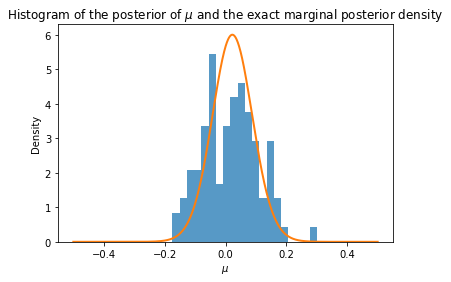

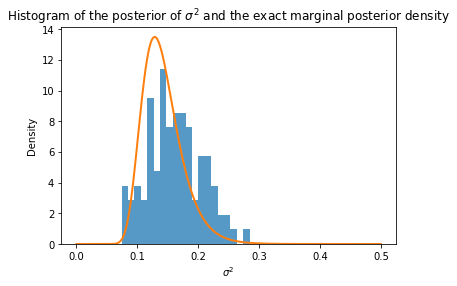

In [8]:
mu0, nu, alpha, beta = prior_args
smean = np.mean(x0)
svar=np.var(x0)
mu0post = (nu*mu0 + n*smean)/(nu+n)
nupost = nu + n
alphapost = alpha + n/2
betapost = beta + .5*n*svar + (n*nu)/(n+nu) * .5*(smean-mu0)**2
tscale = np.sqrt(betapost/(alphapost*nupost))

test, bins, patches = plt.hist(sample[:,0], bins=20, density=True, alpha=0.75)
plt.xlabel('$\mu$')
plt.ylabel('Density')
plt.title('Histogram of the posterior of $\mu$ and the exact marginal posterior density')
x = np.linspace(-.5,.5,1000) 
h = plt.plot(x, ss.t.pdf(x, df=2*alphapost,loc=mu0post, scale=tscale), lw=2)
plt.show()

test, bins, patches = plt.hist(sample[:,1], bins=20, density=True, alpha=0.75)
plt.xlabel('$\sigma^2$')
plt.ylabel('Density')
plt.title('Histogram of the posterior of $\sigma^2$ and the exact marginal posterior density')

x = np.linspace(0,.5,1000) 
h = plt.plot(x, ss.invgamma.pdf(x, alphapost, scale=betapost), lw=2)
plt.show()


Question 1: Can you investigate the effect of the threshold by running the ABC algorithm for different values of epsilon? 
Question 2: Same question for the sample size, niter.
Question 3: As described in the lecture, another version of the ABC rejection algotithm consists in sampling from the prior N times, simulating data from each of theses sampled values of the parameter and selecting the threshold as a certain quartile of the distances between the simulated data and the observed ones. This ABC algorithm allows to control the acceptance rate. Can you implement this second version of the algorithm.   

## The moving average stochastic model

Let's consider the moving average stochastic model introduced during the lecture and use the ABC rejection algorithm to infer the parameters of the model. Recall that a sequence of size n, $(y_n)_n$ from the MA(q) process is defined as follows
$$y_k = u_k +\sum_{i=1}^q \theta_i u_{k-i}$$
where $u_k\sim\mathcal{N}(0,1)$.

We will start by considering the MA(2) process and assume a uniform prior over the triangle defined by the points (-2,1), (2,1) and (0,-1) to fullfill the identifiability condition.

We need to implement functions to 
* simulate from the model
* sample from the prior
* produce a distance between the simulated data and the observed data -- here we will start by using the euclidian distance between the sequences


In [9]:
def simulator_MA2(param, n):
    u = ss.norm.rvs(size = n+2)
    y = np.zeros(n)
    for i in range(0,n):
        y[i] = u[i+2] + param[0]*u[i+1] + param[1]*u[i]
    return y

def distance_euclidian(s,x0):
    return np.sqrt(np.sum((s-x0)**2))

def prior_sample_uniform_triangle(prior_args):
    A,B,C = prior_args
    ps = np.zeros(2)
    r1, r2 = ss.uniform.rvs(size=2)
    P = (1-np.sqrt(r1))*A + (np.sqrt(r1)*(1-r2))*B+(r2*np.sqrt(r1))*C
    return P





We now simulate the observed data from the model with parameters (0.6,0.2) and then infer the parameters of the model using the ABC rejection algorithm using a threshold equal to 15.

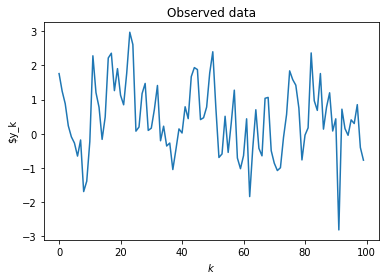


To obtain a sample of size 500, the algorithm had to simulate the model 6526 times. The average acceptance rate is therefore 0.076617.


In [10]:
param = (0.6,0.2)
simulator_args = 100
prior_args=(np.array([-2,1]),np.array([2,1]),np.array([0,-1]))
niter=500
epsilon=15
x0 = simulator_MA2(param, simulator_args)
plt.plot(range(0,simulator_args),x0)
plt.xlabel('$k$')
plt.ylabel('$y_k')
plt.title('Observed data')
plt.show()

samples = rejectionABC(simulator_MA2, simulator_args, 
                      prior_sample_uniform_triangle, prior_args, 
                      niter, 
                      x0, 
                      epsilon,
                      distance_euclidian)


We can plot the scatterplot of the samples of the approximate posterior distribution. The red triangle represents the region of possible parameters

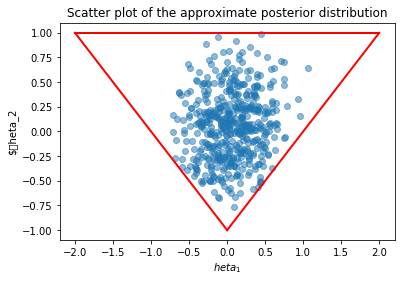

In [11]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5)
plt.plot([-2,2], [1,1], linewidth=2, color='red')
plt.plot([-2,0], [1,-1], linewidth=2, color='red')
plt.plot([0,2], [-1,1], linewidth=2, color='red')
plt.xlabel('$\theta_1$')
plt.ylabel('$\theta_2')
plt.title('Scatter plot of the approximate posterior distribution')
plt.show()

Questions:
1. Run the ABC algorithm (the one above or the version you implemented in the previous section) with different values of the threshold and compare the resulting approximate posterio distributions
2. Implement the autocovariance distance, which is the euclidian distance between the two autocovariances, $\tau_1$ an d $\tau_2$ defined as $$\tau_j=\sum_{k=j+1}^n y_ky_{k-j}$$. 
3. Compare the approximate posterior distribution obtained with the two different distances.

## The ABC-MCMC algorithm
So far, we used the ABC rejection algorith. As presented during the lecture, there exists a variety of more computationally efficient ABC algorithms. In thisn part of the tutorial, we consider the ABC-MCMC algorithm.

The ABC-MCMC method requires
* a simulator (simulator) and its arguments (simulator_args)
* a function to sample from the prior (prior_sample), and its arguments (prior_args)
* the number of samples (niter) we want to draw from the the approximate posterior
* the data (x0)
* athreshold (epsilon)
* a distance function
as well as 
* a function to evaluate the prior distribution for a specific value of the parameters
* a proposal distribution and its arguments.

Below is a simple version of this algorithm where an independent normal random walk is used as a proposal for each parameters. This proposal distribution being symmetric, it does not contribute to the acceptance probability.


In [12]:
def MCMC_ABC(simulator, simulator_args, 
             prior_sample, prior_eval, prior_args, 
             niter, x0, epsilon, distance, 
             proposal_args):
    
    npar = len(prior_sample(prior_args))
    sample = np.zeros((niter,npar))
    
    # Sample first parameter from ABC rejection
    param = prior_sample(prior_args)
    s = simulator(param, simulator_args)
    while (distance(s,x0)>epsilon):
        param = prior_sample(prior_args)
        s = simulator(param, simulator_args)
    sample[0,:] = param
    # Evaluate the prior for this parameter
    pold = prior_eval(param, prior_args)
    
    # MCMC algorithm
    for i in tqdm_notebook(range(1,niter),desc='Samples'):
        # Generate parameter from a Random walk for each dimension with standard deviation defined in proposal_args
        param = sample[i-1,:]+ss.norm.rvs(size=npar)*proposal_args
        p = prior_eval(param, prior_args)
        # Only consider this parameter if it is within the prior support, otherwise reject it.
        if p>0:
            # Generate s from simulator
            s = simulator(param, simulator_args)
            # generate u from uniform
            u = ss.uniform.rvs(size=1)
            # Calculate acceptance probbaility
            ap = p/pold
            if u<=ap and distance(s,x0)<=epsilon:
                sample[i,:] = param
                # Keep the prior evaluation for this parameter 
                pold=p
            else:
                sample[i,:] = sample[i-1,:]
        else:
            sample[i,:] = sample[i-1,:]
    
    return sample





We use the ABC-MCMC algorithm to infer the parameter of the MA(2) model. As for the previous section, the data are generated from the model with parameters (0.6,0.2) and we consider a uniform distribution over the triangle to ensure idendifiability. We run the ABC-MCMC algorithm for 500 iterations with a threshold equal to 15.

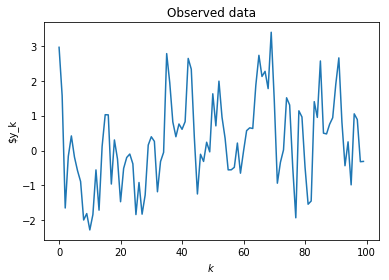

In [33]:
param = (0.6,0.2)
simulator_args = 100
prior_args=(np.array([-2,1]),np.array([2,1]),np.array([0,-1]))
niter=10000
epsilon=15
proposal_args = (0.2,0.2)

x0 = simulator_MA2(param, simulator_args)
plt.plot(range(0,simulator_args),x0)
plt.xlabel('$k$')
plt.ylabel('$y_k')
plt.title('Observed data')
plt.show()

def prior_eval_uniform_triangle(p_test, prios_args):       
    p0, p1, p2 = prior_args
    dX = p_test[0] - p0[0]
    dY = p_test[1] - p0[1]
    dX20 = p2[0] - p0[0]
    dY20 = p2[1] - p0[1]
    dX10 = p1[0] - p0[0]
    dY10 = p1[1] - p0[1]
    s_p = (dY20*dX) - (dX20*dY)
    t_p = (dX10*dY) - (dY10*dX)
    D = (dX10*dY20) - (dY10*dX20)
    if D > 0:
        if (s_p >= 0) and (t_p >= 0) and (s_p + t_p) <= D: 
            return 1
        else:
            return 0
    else:
        if (s_p <= 0) and (t_p <= 0) and (s_p + t_p) >= D:
            return 1
        else:
            return 0 
    

samples = MCMC_ABC(simulator_MA2, simulator_args, 
                  prior_sample_uniform_triangle, prior_eval_uniform_triangle, prior_args, 
                  niter, x0, epsilon, 
                  distance_euclidian, proposal_args)
    


Let's run a second chain and plot the traceplots associated to each parameter.

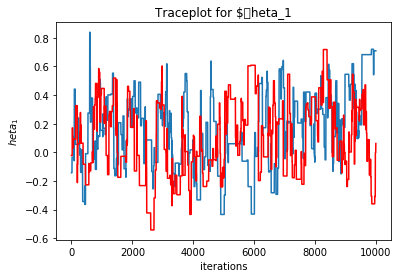

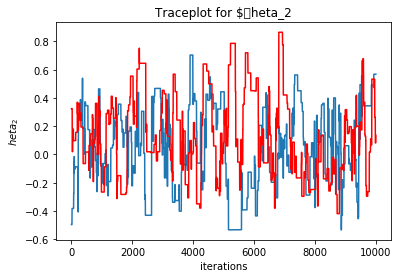

In [34]:
samples2 = MCMC_ABC(simulator_MA2, simulator_args, 
                  prior_sample_uniform_triangle, prior_eval_uniform_triangle, prior_args, 
                  niter, x0, epsilon, 
                  distance_euclidian, proposal_args)

plt.plot(range(0,niter),samples[:,0])
plt.plot(range(0,niter),samples2[:,0], color='red')
plt.xlabel('iterations')
plt.ylabel('$\theta_1$')
plt.title('Traceplot for $\theta_1')
plt.show()
plt.plot(range(0,niter),samples[:,1])
plt.plot(range(0,niter),samples2[:,1], color='red')
plt.xlabel('iterations')
plt.ylabel('$\theta_2$')
plt.title('Traceplot for $\theta_2')
plt.show()

The scatterplot of the samples of the approximate posterior distribution resulting from the ABC-MCMC algorithm can be seen below. We consider a burn-in period of 1000 iterations. The red triangle represents the region of possible parameters

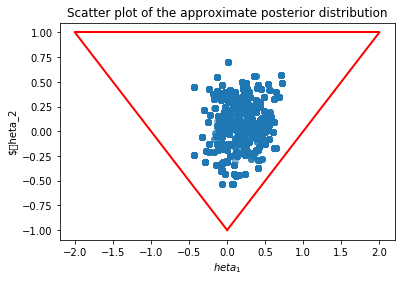

In [36]:
plt.scatter(samples[1000:niter,0], samples[1000:niter,1], alpha=0.5)
plt.plot([-2,2], [1,1], linewidth=2, color='red')
plt.plot([-2,0], [1,-1], linewidth=2, color='red')
plt.plot([0,2], [-1,1], linewidth=2, color='red')
plt.xlabel('$\theta_1$')
plt.ylabel('$\theta_2')
plt.title('Scatter plot of the approximate posterior distribution')
plt.show()

Questions: 
* Investigate the impact of the choice of the proposal.
* Compare the computational cost of the ABC rejection and the ABC-MCMC algorithms. To do this, you will need to compute the acceptance rate for both algorithms.


## Model Selection

Approximate Bayesian Computation can also be used for model comparison. The algorithm is similar to the ABC rejection algorithm for parameter inference. 

In [17]:
def ABC_modelSelection(simulator0, simulator0_args, simulator1, simulator1_args, 
                       prior0_sample, prior0_args, prior1_sample, prior1_args,
                       prior_model, 
                       niter, x0, epsilon, distance):
    
    npar0 = len(prior0_sample(prior0_args))
    npar1 = len(prior1_sample(prior1_args))
    # The following array will contain the model index in the first column and the parameter in the second column
    sample = np.zeros((niter,2), dtype=object)
    for i in tqdm_notebook(range(0,niter),desc='Samples'):
        m = ss.bernoulli.rvs(prior_model, size=1)
        if m==0:
            param = prior0_sample(prior0_args)
            s = simulator0(param, simulator0_args)
        else:
            param = prior1_sample(prior1_args)
            s = simulator1(param, simulator1_args)
            
        while (distance(s,x0)>epsilon):
            m = ss.bernoulli.rvs(prior_model, size=1)
            if m==0:
                param = prior0_sample(prior0_args)
                s = simulator0(param, simulator0_args)
            else:
                param = prior1_sample(prior1_args)
                s = simulator1(param, simulator1_args)
        sample[i,0] = m
        sample[i,1] = param
    return sample

We apply it to compare the MA(1) and MA(2) models from a time series generated using the MA(1) model with parameter 0.6. 

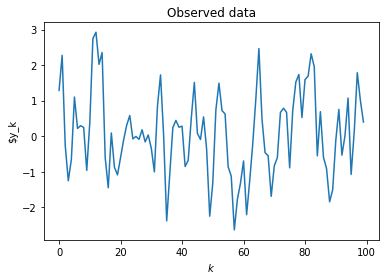

In [19]:
def simulator_MA1(param, n):
    u = ss.norm.rvs(size = n+1)
    y = np.zeros(n)
    for i in range(0,n):
        y[i] = u[i+1] + param[0]*u[i]
    return y

def prior_sample_uniform(prior_args):
    m, M = prior_args
    return ss.uniform.rvs(loc=m, scale=M-m, size=1)
    

simulator_args = 100
prior_args=(np.array([-2,1]),np.array([2,1]),np.array([0,-1]))
niter=500
epsilon=14
proposal_args = (0.1,0.1)

param = [0.6]
x0 = simulator_MA1(param, simulator_args)
plt.plot(range(0,simulator_args),x0)
plt.xlabel('$k$')
plt.ylabel('$y_k')
plt.title('Observed data')
plt.show()

simulator0 = simulator_MA1
simulator1 = simulator_MA2
prior0_sample = prior_sample_uniform
prior0_args=(-1,1)
prior1_sample = prior_sample_uniform_triangle
prior1_args=(np.array([-2,1]),np.array([2,1]),np.array([0,-1]))
prior_model= .5
distance = distance_euclidian

samples = ABC_modelSelection(simulator0, simulator_args, simulator1, simulator_args, 
                       prior0_sample, prior0_args, prior1_sample, prior1_args,
                       prior_model, 
                       niter, x0, epsilon, distance)





Below is the approximate posterior probability of the two models as well as the approximate posterior probabilites of the parameters for each model.


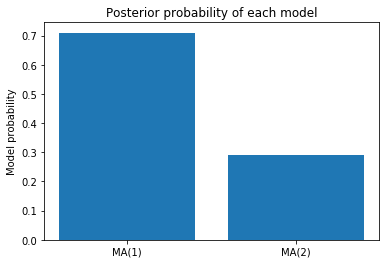

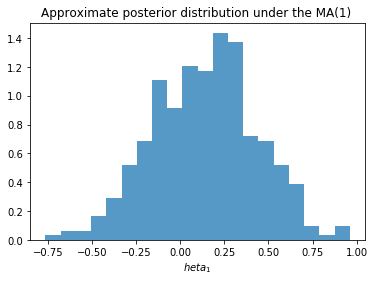

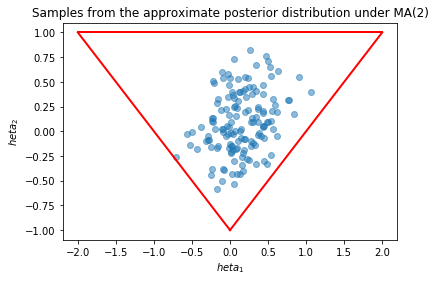

In [22]:
h=plt.bar(['MA(1)','MA(2)'], [sum(samples[:,0]==0)/niter, sum(samples[:,0]==1)/niter])
plt.ylabel('Model probability')
plt.title('Posterior probability of each model')
plt.show()

s0 = samples[samples[:,0]==0,1]
s0 = np.array(list(s0), dtype=np.float)
test, bins, patches = plt.hist(s0, bins=20, density=True, alpha=0.75)
plt.xlabel('$\theta_1$')
plt.title('Approximate posterior distribution under the MA(1) ')
plt.show()

s1 = samples[samples[:,0]==1,1]
s1 = np.array(list(s1), dtype=np.float)
plt.scatter(s1[:,0], s1[:,1], alpha=0.5)
plt.plot([-2,2], [1,1], linewidth=2, color='red')
plt.plot([-2,0], [1,-1], linewidth=2, color='red')
plt.plot([0,2], [-1,1], linewidth=2, color='red')
plt.xlabel('$\theta_1$')
plt.ylabel('$\theta_2$')
plt.title('Samples from the approximate posterior distribution under MA(2)')
plt.show()

Questions:
1. Compare the model posterior probability when decreasing the threshold.
2. As discussed in the lecture, the summary statistics can play a very important role for model selection. Compare the inference when using the distance based on autocovariances
3. Use the model selection algorithm to discriminate between a Laplace distribution and a Normal distribution.